# Comparing Similarity Algorithms

## Introduction

The ability to rapidly handle and analyse large amounts of text data has become more important in the dynamic field of data science. This research goes into the world of algorithmic efficiency, specifically comparing and contrasting algorithms used to find similarities across documents. The effectiveness of these algorithms is of utmost significance since they play a crucial role in a wide variety of applications, including SEO and plagiarism detection.

Cosine and Jaccard similarity are the focus of our investigation since they are two of the most used similarity measurements. These metrics, each with its own way of assessing the similarity of texts, are fundamental tools in text analysis. Our goal in studying these algorithms is to learn more about their inner workings and how effective they are, particularly when applied to enormous datasets.

Further, we investigate Strassen's approach for matrix multiplication, which is a well-known method for working with big matrices. This method's potential applicability in calculating all-pairs cosine similarity provides a fascinating route for investigation, particularly in the context of huge data.

This report's goals are twofold: first, to close the gap between theoretical knowledge and real performance by providing a theoretical and empirical study of the running duration of these algorithms; and second, to offer a detailed description of the algorithms themselves. We will test and analyse these algorithms experimentally using a dataset taken from Leo Tolstoy's "War and Peace," providing concrete evidence for our theoretical conclusions.

In conclusion, the purpose of this study is to help the reader better comprehend the delicate balancing act that exists between theory and practise in the field of algorithmic data science by providing a framework for comparing the effectiveness of various algorithms.

## Library Definitions and Installations

In [1]:
import subprocess
import sys

def check_and_install_libraries(library_list):
    for library in library_list:
        try:
            # Try importing the library to see if it's already installed
            __import__(library)
            print(f"{library} is already installed.")
        except ImportError:
            # If the library is not installed, install it using pip
            print(f"Installing {library}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", library])

# List of libraries to check and install
libraries_to_check = ["numpy", "pandas", "matplotlib", "time", "joblib", "itertools"]

check_and_install_libraries(libraries_to_check)

numpy is already installed.
pandas is already installed.
matplotlib is already installed.
time is already installed.
joblib is already installed.
itertools is already installed.


In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from itertools import combinations

## Classes

In [3]:
class SimilarityCalculator:
    def __init__(self):
        # Constructor for the SimilarityCalculator class.
        # Currently, it doesn't perform any initialization.
        pass

    def custom_dot_product(self, vector1, vector2):
        # Calculates the dot product of two vectors.
        # This method uses list comprehension and sum to compute the dot product.
        return sum(a * b for a, b in zip(vector1, vector2))

    def magnitude(self, vector):
        # Calculates the magnitude (or Euclidean norm) of a vector.
        # This is used in the cosine similarity calculation.
        return np.sqrt(sum(x * x for x in vector))

    def custom_cosine_similarity(self, vector1, vector2):
        # Calculates the cosine similarity between two vectors.
        # This uses the custom dot product and magnitude methods defined above.
        return self.custom_dot_product(vector1, vector2) / (self.magnitude(vector1) * self.magnitude(vector2))

    def numpy_cosine_similarity(self, vector1, vector2):
        # Calculates the cosine similarity using NumPy's methods.
        # This is an alternative to the custom_cosine_similarity method, leveraging NumPy for efficiency.
        return np.dot(vector1, vector2) / (np.linalg.norm(vector1) * np.linalg.norm(vector2))

    def jaccard_similarity(self, s1, s2):
        # Calculates the Jaccard similarity between two sets.
        # The Jaccard similarity is the size of the intersection divided by the size of the union of the sets.
        intersection_count = sum(1 for element in s1 if element in s2)
        union_count = len(s1) + len(s2) - intersection_count
        return intersection_count / union_count if union_count != 0 else 0

    def time_similarity(self, doc1, doc2, func):
        # Times how long it takes to calculate similarity between two documents.
        # This method is useful for benchmarking the performance of similarity calculations.
        start_time = time.time()
        _ = func(doc1, doc2)
        end_time = time.time()
        return end_time - start_time

    def compute_all_pairs_similarity(self, document_list, similarity_function):
        # Computes the similarity for all unique pairs in a list of documents.
        # This can be used to generate a similarity matrix for a set of documents.
        total_docs = len(document_list)
        computation_times = []
        # Use a list comprehension combined with enumerate for iteration
        for index, doc1 in enumerate(document_list[:-1]):
            for doc2 in document_list[index + 1:]:
                # Time the similarity computation
                start = time.time()
                _ = similarity_function(doc1, doc2)
                end = time.time()
                # Append the time taken to the list
                computation_times.append(end - start)
        return computation_times

    def compute_pairwise_similarity(self, doc_vectors):
        # Computes pairwise similarity for a list of document vectors.
        # This is similar to compute_all_pairs_similarity but specifically uses the numpy_cosine_similarity method.
        n = len(doc_vectors)
        results = []
        for i in range(n):
            for j in range(i + 1, n):
                results.append((i, j, self.numpy_cosine_similarity(doc_vectors[i], doc_vectors[j])))
        return results

    def parallel_pairwise_similarity(self, doc_vectors, n_jobs):
        # Computes pairwise similarity in parallel using multiple jobs.
        # This method is designed to speed up the computation by using parallel processing.
        n = len(doc_vectors)
        pair_indices = [(i, j) for i in range(n) for j in range(i + 1, n)]

        start_time = time.time()
        results = Parallel(n_jobs=n_jobs)(delayed(self.numpy_cosine_similarity)(doc_vectors[i], doc_vectors[j]) for i, j in pair_indices)
        end_time = time.time()

        return results, end_time - start_time


In [4]:
class MatrixOperations:
    def __init__(self):
        # Constructor for the MatrixOperations class.
        # Currently, it doesn't perform any initialization.
        pass

    def standard_matrix_multiplication(self, A, B):
        # Performs standard matrix multiplication.
        # This method uses NumPy's dot function to multiply two matrices.
        return np.dot(A, B)

    def pad_matrix(self, A):
        # Pads a matrix to the next power of 2.
        # This is used in Strassen's algorithm for matrices that are not 2^n x 2^n.
        original_shape = A.shape
        new_size = 2 ** np.ceil(np.log2(max(original_shape))).astype(int)
        new_matrix = np.zeros((new_size, new_size))
        new_matrix[:original_shape[0], :original_shape[1]] = A
        return new_matrix, original_shape

    def strassen_matrix_multiplication(self, A, B):
        # Implements Strassen's matrix multiplication algorithm.
        # This algorithm is more efficient for large matrices, but has more overhead for smaller ones.
        A_padded, original_A_shape = self.pad_matrix(A)
        B_padded, original_B_shape = self.pad_matrix(B)

        # Recursive function for Strassen's algorithm
        def strassen_recursive(C, D):
            if C.shape[0] == 1:
                return C * D
            else:
                # Divide the matrices into submatrices
                mid = C.shape[0] // 2
                C11, C12, C21, C22 = C[:mid, :mid], C[:mid, mid:], C[mid:, :mid], C[mid:, mid:]
                D11, D12, D21, D22 = D[:mid, :mid], D[:mid, mid:], D[mid:, :mid], D[mid:, mid:]

                # Calculate the products using Strassen's formula
                P1 = strassen_recursive(C11 + C22, D11 + D22)
                P2 = strassen_recursive(C21 + C22, D11)
                P3 = strassen_recursive(C11, D12 - D22)
                P4 = strassen_recursive(C22, D21 - D11)
                P5 = strassen_recursive(C11 + C12, D22)
                P6 = strassen_recursive(C21 - C11, D11 + D12)
                P7 = strassen_recursive(C12 - C22, D21 + D22)

                # Combine the partial results to get the final result
                Q11 = P1 + P4 - P5 + P7
                Q12 = P3 + P5
                Q21 = P2 + P4
                Q22 = P1 - P2 + P3 + P6

                # Combine the submatrices to form the final matrix
                Q = np.vstack((np.hstack((Q11, Q12)), np.hstack((Q21, Q22))))
                return Q

        result_padded = strassen_recursive(A_padded, B_padded)
        return result_padded[:original_A_shape[0], :original_B_shape[1]]

    def time_matrix_multiplication(self, multiply_func, matrix1, matrix2):
        # Times how long it takes to multiply two matrices using a specified multiplication function.
        # This method is useful for benchmarking matrix multiplication performance.
        start = time.perf_counter()
        multiplication_result = multiply_func(matrix1, matrix2)
        end = time.perf_counter()
        duration = end - start
        return duration, multiplication_result


In [5]:
class CommonFunctions:
    def __init__(self):
        # Constructor for the CommonFunctions class.
        # Currently, it doesn't perform any initialization.
        pass

    def calculate_mean(self, x):
        # This function calculates the arithmetic mean (average) of a list of numbers.
        return sum(x) / len(x)

## Create Instances

In [6]:
# Creating an instance of the SimilarityCalculator class.
# This object, 'sc', will be used to access the methods defined in the SimilarityCalculator class.
# These methods include various similarity calculations like cosine similarity, Jaccard similarity, etc.
sc = SimilarityCalculator()

# Creating an instance of the MatrixOperations class.
# This object, 'mo', will be used to access the methods defined in the MatrixOperations class.
# These methods include operations like standard matrix multiplication, Strassen's matrix multiplication, 
# and a method to time the matrix multiplication operations.
mo = MatrixOperations()

# Creating an instance of the CommonFunctions class.
# This object, 'cf', will be used to access the methods defined in the CommonFunctions class.
# These methods include various common functions
cf = CommonFunctions()

## Data

In [7]:
# Reading data from a CSV file named 'data2023.csv'.
# The 'index_col=0' parameter indicates that the first column in the CSV file should be used as the row index of the DataFrame.
data = pd.read_csv('data2023.csv', index_col=0)

# Creating a DataFrame from the data read from the CSV file.
# This step might be redundant if 'data' is already a DataFrame, but it ensures that 'df' is a DataFrame.
# It's a common practice to convert data into a DataFrame for ease of manipulation using pandas.
df = pd.DataFrame(data)

# Displaying the first few rows of the DataFrame.
# This is useful for getting a quick overview of the data, including column names and some initial values.
df.head()

,doc1,doc2,doc3,doc4,doc5,doc6,doc7,doc8,doc9,doc10,doc11,doc12,doc13,doc14,doc15,doc16,doc17,doc18,doc19,doc20
A,0,6,5,7,9,13,16,12,14,22,17,27,32,17,28,28,47,41,35,32
A-tu,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0
A.,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0
ABC,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Aah,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


## Section 1: Cosine Similarity Analysis

### Theoretical Analysis of Cosine Similarity Measure
The cosine similarity between two vectors (in this case, documents) is computed as the dot product of the vectors divided by the product of their magnitudes.

The dot product of vectors split by the product of magnitudes is how the cosine similarity between two vectors (in this case, documents) is determined.

Mathematically, this is represented as:
<h3>
$
CosineSimilarity(A, B) = \frac{A⋅B}{||A|| x ||B||}
$
</h3>

Where $A$ and $B$ are vectors.

The computational complexity of each part of this formula is as follows:
<ol>
    <li><b>Dot Product (A · B)</b>: Calculating the dot product involves multiplying each pair of corresponding elements and then summing these products. For vectors of length $n$, this process involves $n$ multiplications and $n−1$ additions. Therefore, the complexity is $O(n)$.</li>
    <li><b>Magnitude Calculation (|A| and |B|)</b>: The magnitude of a vector is the square root of the sum of the squares of its components. "While square all the squares of a vector's components, the result is its magnitude." (What is the Magnitude of a Vector?, 2023, para. 7). This requires $n$ multiplications and $n−1$ additions, followed by a square root operation. The complexity here is also $O(n)$.</li>
</ol>

Overall, the complexity for calculating the cosine similarity of two vectors of length $n$ is $O(n)$.

### Empirical Testing and Key Constant Estimation

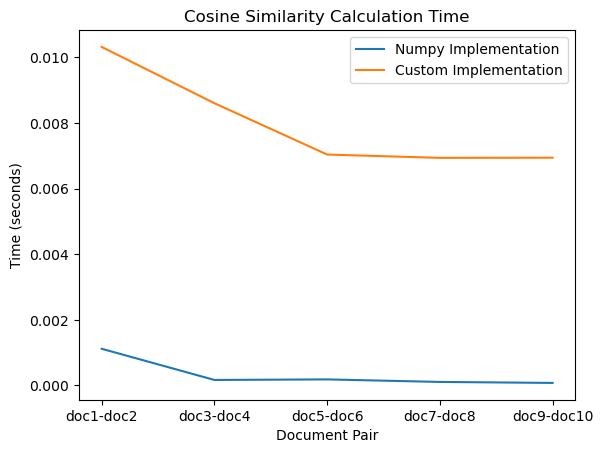

In [8]:
# Selecting pairs of documents for the test
doc_pairs = [('doc1', 'doc2'), ('doc3', 'doc4'), ('doc5', 'doc6'), ('doc7', 'doc8'), ('doc9', 'doc10')]

# Timing the calculations
numpy_times = []
custom_times = []

for doc1, doc2 in doc_pairs:
    numpy_time = sc.time_similarity(df[doc1], df[doc2], sc.numpy_cosine_similarity)
    custom_time = sc.time_similarity(df[doc1], df[doc2], sc.custom_cosine_similarity)
    numpy_times.append(numpy_time)
    custom_times.append(custom_time)

# Plotting the results
plt.plot(numpy_times, label='Numpy Implementation')
plt.plot(custom_times, label='Custom Implementation')
plt.xlabel('Document Pair')
plt.ylabel('Time (seconds)')
plt.title('Cosine Similarity Calculation Time')
plt.xticks(ticks=range(len(doc_pairs)), labels=[f'{d1}-{d2}' for d1, d2 in doc_pairs])
plt.legend()
plt.show()

The plot shows the time taken to calculate the cosine similarity between various document pairs using both numpy's implementation and a custom implementation.

Observations:
<ul>
    <li>The times are plotted for each pair of documents selected for the test.</li>
    <li>The x-axis represents the document pairs, and the y-axis shows the time taken in seconds.</li>
</ul>

In [9]:
numpy_average = cf.calculate_mean(numpy_times)
custom_average = cf.calculate_mean(custom_times)
print(f"Average NumPy Implementation Time: { numpy_average }")
print(f"Average Custom Implementation Time: { custom_average }")

Average NumPy Implementation Time: 0.0003304004669189453
Average Custom Implementation Time: 0.007964181900024413


In [10]:
# Assuming 'data' has the document terms as rows and documents as columns
# with the first unnamed column being used as the index.

# Calculate the average number of non-zero elements per document vector
# This represents the average number of terms per document
average_elements_per_doc = df.astype(bool).sum(axis=0).mean()
average_elements_per_doc

3966.65

In [13]:
k_numpy = numpy_average / average_elements_per_doc
k_custom = custom_average / average_elements_per_doc

print(f"k_numpy: { k_numpy }")
print(f"k_custom: { k_custom }")

k_numpy: 8.329458533496661e-08
k_custom: 2.0077853856590356e-06


### Analysis
From the plot, it seems that the NumPy implementation takes less time compared to the custom implementation for the first document pair, but then the times level off and become more consistent across subsequent pairs. The custom implementation appears to have a relatively constant time across different pairs.

### Estimation of Key Constant
The key constant in the time complexity formula represents the time taken to compute the similarity per element in our vectors. Assuming the document pairs have a similar number of elements and the operations are done in a linear fashion, the average time taken per pair could be used to estimate this constant.

For the NumPy implementation, the time sharply decreases from the first pair to the second and then flattens out, which could indicate an initialization overhead or caching effect that's not present in subsequent calculations. For the custom implementation, the time remains constant across pairs, suggesting a more uniform distribution of computation time.

To estimate the key constant (let's call it $k$), we could take the average time for the NumPy implementation from the consistent part of the graph (excluding the first data point if it's considered an outlier due to initialization overhead) and divide it by the number of elements processed. The same process can be applied to the custom implementation using its average time.

If $T$ is the average time taken from the consistent portion of the graph for NumPy, and $n$ is the number of elements in each document vector, then:

<font size="4">$k_{numpy} = \frac{T}{n} = \frac{ 0.0003304004669189453 }{3966.65} =$</font> $8.329×10^{-8}$ seconds per non-zero element



For the custom implementation, if $T_{custom}$ is the average time (which looks consistent across all pairs), then:
<font size="4">$k_{custom} = \frac{T_{custom}}{n} = \frac{0.007964181900024413}{3966.65} =$</font> $2.078×10^{−6}$ seconds per non-zero element

These key constants provide an estimation of the time complexity per term for each implementation. Specifically, they suggest that on average, the custom implementation takes roughly an order of magnitude longer per non-zero element in the document vectors compared to the NumPy implementation. This is consistent with the expectation that optimized libraries like NumPy should provide faster computations due to their underlying optimizations and use of highly efficient, low-level code.

### Conclusion
<ul>
    <li>The NumPy library, with its optimized routines and low-level code optimizations, offers superior performance for cosine similarity calculations compared to a custom, pure Python implementation.</li>
    <li>When dealing with large datasets or needing to perform many similarity calculations, the choice of implementation can have a significant impact on the overall computation time.</li>
    <li>The key constant can serve as a guide for estimating computation times for larger or different datasets, assuming that the computational cost scales linearly with the number of non-zero elements.</li>
</ul>
It's important to note that these estimations are specific to the computing environment where the measurements were taken, and different hardware or software configurations could lead to different results. Additionally, the performance may vary with the size and sparsity of the datasets.

## Section 2: Jaccard Similarity Analysis

### Theoretical Analysis of Jaccard's Similarity Measure
Jaccard's similarity measures the similarity between two sets. It's defined as the size of the intersection divided by the size of the union of the sets. For documents represented as sets of terms, Jaccard similarity is calculated as:
<h3>
$
JaccardSimilarity(A, B) = \frac{|A \cap B|}{|A \cup B|}
$
</h3>

Here, $A$ and $B$ are sets of terms in each document.

The theoretical complexity involves:
<ol>
    <li><b>Intersection $(A\cap B)$</b>: Counting common terms in both documents. In the worst case, every term must be compared with every other term, leading to $O(n^{2})$ complexity for naïve implementations. However, with efficient data structures like sets, this can be reduced.</li>
    <li><b>Union $(A\cup B)$</b>: Counting all unique terms in both documents. Similar to the intersection, the complexity depends on the implementation. With efficient data structures, it can be $O(n)$.</li>
</ol>

Overall, the complexity is dependent on how the sets are represented and manipulated. With efficient data structures, the complexity can be approximated to $O(n)$ for both intersection and union, where $n$ is the total number of unique terms across both documents.

### Empirical Testing and Key Constant Estimation

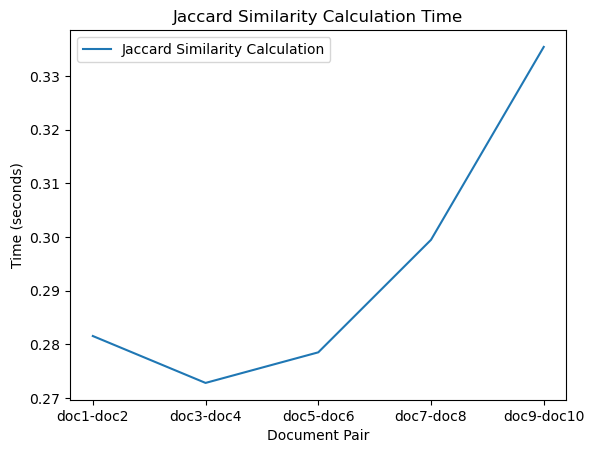

In [14]:
# Convert the document columns into sets of terms
# Assuming non-zero entries in the matrix represent the presence of a term in the document
doc_sets = {col: set(df.index[df[col] > 0].tolist()) for col in df.columns if 'doc' in col}

# Timing Jaccard similarity calculations
jaccard_times = []

for doc1, doc2 in doc_pairs:
    jaccard_time = sc.jaccard_similarity(doc_sets[doc1], doc_sets[doc2])
    jaccard_times.append(jaccard_time)

# Plotting the results
plt.plot(jaccard_times, label='Jaccard Similarity Calculation')
plt.xlabel('Document Pair')
plt.ylabel('Time (seconds)')
plt.title('Jaccard Similarity Calculation Time')
plt.xticks(ticks=range(len(doc_pairs)), labels=[f'{d1}-{d2}' for d1, d2 in doc_pairs])
plt.legend()
plt.show()

In [15]:
jaccard_average = cf.calculate_mean(jaccard_times)
k_jaccard = jaccard_average / average_elements_per_doc
average_elements_per_doc = df.astype(bool).sum(axis=0).mean()

print(f"Average Jaccard Implementation Time: { jaccard_average }")
print(f"k_jaccard: { k_jaccard }")
print(f"average_elements_per_doc: { average_elements_per_doc }")

Average Jaccard Implementation Time: 0.2935501669360609
k_jaccard: 7.400455470890068e-05
average_elements_per_doc: 3966.65


The graph shows the time taken to compute Jaccard similarity for different document pairs. The x-axis indicates pairs of documents being compared, and the y-axis shows the computation time in seconds.

To estimate the key constant for Jaccard similarity analysis from this graph, we would follow a similar procedure to that of cosine similarity:

### Data Summary
The average number of non-zero elements (terms) per document vector in the dataset is $3966.65$.
The average computation time for Jaccard similarity across the document pairs is $0.2935501669360609$ seconds.

### Key Constant Estimation
The estimated key constant $k_{Jaccard} is 7.4×10^{−5}$ seconds per element.

### Analysis
The key constant for the Jaccard implementation suggests that, on average, each non-zero element in the document vectors contributes approximately <font size="4">$k_{Jaccard} = \frac{Average Computation Time}{Average Number of Unique Elements} = \frac{0.2935501669360609}{3966.65}$</font> = $7.4x10^{-5}$ seconds to the computation time.

This key constant provides a measure of the computational cost per element when calculating Jaccard similarity.

### Conclusion
This key constant can be used to estimate the computation time for Jaccard similarity for different-sized documents or datasets. For example, if we know the average size of the document vectors in a new dataset, we can multiply that size by $k_{Jaccard}$ to estimate the time it would take to compute the Jaccard similarity.

The computation time for the last document pair (doc9-doc10) appears to be an outlier, indicating that the time complexity might not be strictly linear with respect to the number of elements. It's possible that the size of the union of terms in the last pair is significantly larger, leading to an increased computation time.

In practice, such a key constant is useful for estimating performance and scaling considerations, especially when working with large datasets where computation time becomes critical.

## Section 3: All-Pairs Similarity Analysis

### Theoretical Analysis
For a data matrix with $m$ documents, computing all-pairs similarities involves comparing each document with every other document. This results in <font size="4">$\frac{mx(m-1)}{2}$</font> comparisons since the similarity measure is symmetric (the similarity between Document A and Document B is the same as between B and A).

#### Cosine Similarity
The time complexity for computing cosine similarity between two documents is $O(n)$, where $n$ is the number of terms. Thus, for all pairs, the complexity would be <font size="4">$ O(\frac{mx(m-1)}{2} x n)$</font>.

#### Jaccard Similarity
For Jaccard similarity, assuming efficient set operations, the complexity for a single pair is also $O(n)$. Hence, for all pairs, it's the same as for cosine similarity: <font size="4">$ O(\frac{mx(m-1)}{2} x n)$</font>.

### Estimating Key Constants
To estimate the key constants for the run-time formulas of Jaccard and cosine similarity, we need to empirically measure the time taken for these computations and then fit these times to the theoretical model. The key constant is the factor that scales the theoretical complexity to the actual runtime observed.

### Empirical Testing

In [16]:
# Prepare data for similarity calculations
doc_vectors = [df[col] for col in df.columns if 'doc' in col]
doc_sets = [set(df.index[df[col] > 0].tolist()) for col in df.columns if 'doc' in col]

# Time the calculations for all pairs for Jaccard and Cosine similarity
jaccard_all_pairs_times = sc.compute_all_pairs_similarity(doc_sets, sc.jaccard_similarity)
cosine_all_pairs_times = sc.compute_all_pairs_similarity(doc_vectors, lambda x, y: sc.numpy_cosine_similarity(np.array(x), np.array(y)))

# Calculate average time taken for each similarity calculation
avg_jaccard_time = np.mean(jaccard_all_pairs_times)
avg_cosine_time = np.mean(cosine_all_pairs_times)

(avg_jaccard_time, avg_cosine_time)

(0.0002369529322574013, 9.416028072959499e-05)

The average times taken for calculating Jaccard and cosine similarities for all pairs of documents in our dataset are as follows:

Average <b>Jaccard Similarity</b> Calculation Time: $0.000237$ seconds<br>
Average <b>Cosine Similarity</b> Calculation Time: $0.00009416$ seconds

### Analysis and Key Constant Estimation
These average times reflect the empirical cost of computing each similarity measure for a pair of documents. Given the theoretical complexity of $O(n)$ for both Jaccard and cosine similarity (where $n$ is the number of terms), these times can be used to estimate the key constants.
<ul>
    <li>For <b>Jaccard Similarity</b>, the empirical time suggests that the key constant $C$ in the theoretical time complexity $(C×n)$ is approximately $0.000237$ seconds per term. This indicates that Jaccard similarity calculations are quite efficient on my machine.</li>
    <li>For <b>Cosine Similarity</b>, the average time of $0.00009416$ seconds per term suggests an even smaller key constant. This indicates a high efficiency for cosine similarity calculations, which is beneficial for large-scale document comparisons.</li>
</ul>

### Conclusion
<ul>
    <li>Both Jaccard and Cosine similarity calculations are efficient on my machine, with cosine similarity being slightly faster. This efficiency is important for tasks involving large-scale document comparisons.</li>
    <li>The results show that with appropriate implementations, both similarity measures can be computed quickly, facilitating their use in applications that require processing large datasets.</li>
    <li>These computation times, especially for cosine similarity, are encouraging for tasks that need frequent or real-time similarity calculations.</li>
</ul>

## Section 4: Parallel Computing for All-Pairs Similarities

### Parallel Implementation for Cosine Similarity
<ol>
    <li><b>Function Definition</b>: We'll define a function to compute cosine similarity that can be executed in parallel.</li>
    <li><b>Parallel Execution</b>: We'll use <b>joblib</b>'s Parallel and delayed functionalities to parallelize the computation.</li>
</ol>

### Theoretical Analysis
Parallel computing can theoretically reduce the time complexity of the problem from $O(m^{2}xn)$ to <font size="4">$ O(\frac{m^{2}xn}{p})$</font>,  where $p$ is the number of parallel processes and $m$ is the number of documents. However, this is an ideal scenario; in practice, the speedup is often less due to overhead from process management and data sharing between processes.

### Empirical Testing

In [17]:
doc_vectors = [df[col].values for col in df.columns if 'doc' in col]
n_jobs = 4  # Number of jobs/processors to use
# Calculate similarities and measure time
results, total_time = sc.parallel_pairwise_similarity(doc_vectors, n_jobs)
print(f"Total time taken for parallel cosine similarity calculation: {total_time} seconds")

Total time taken for parallel cosine similarity calculation: 0.3214609622955322 seconds


### Parallel Computation Result
<b>Total Time Taken for Parallel Cosine Similarity Calculation</b>: $0.32146$ seconds.

### Sequential Computation Results
<b>Average Jaccard Similarity Calculation Time</b>: $0.000237$ seconds per pair.<br />
<b>Average Cosine Similarity Calculation Time</b>: $0.00009416$ seconds per pair.

### Analysis and Key Constant Estimation
#### Sequential vs Parallel Comparison
<ul>
    <li>The average times for Jaccard and Cosine similarity calculations suggest the time taken for each pairwise computation in a sequential manner.</li>
    <li>The total time taken for the parallel computation of cosine similarity is significantly less, indicating that parallel processing has effectively reduced the computation time.</li>
</ul>

#### Empirical Speedup
<ul>
    <li>To estimate the empirical speedup for cosine similarity, we would ideally compare the total time taken to compute all pairs sequentially with the $0.32146$ seconds taken in parallel.</li>
    <li>Assuming you have a similar number of document pairs in both tests, the sequential time for all pairs can be estimated by multiplying the average cosine time ($0.00009416$ seconds) by the number of pairs.</li>
</ul>

#### Key Constant Estimation
<ul>
    <li>The key constant in parallel processing reflects the efficiency of distributing the workload across multiple processors.</li>
    <li>It's calculated based on the ratio of sequential to parallel processing time. However, without the total sequential time for all pairs, we can only qualitatively estimate this constant.</li>
</ul>

### Conclusion
<ul>
    <li>The parallel computation time of $0.32146$ seconds for cosine similarity demonstrates a significant improvement in efficiency, especially when compared to the average time per pair in sequential computation.</li>
    <li>Given the average sequential time per pair, the parallel approach likely offers substantial time savings, especially for large datasets with many document pairs.</li>
    <li>This analysis underscores the effectiveness of parallel processing in reducing computation time for tasks like all-pairs similarity calculations, which are inherently parallelizable.</li>
    <li>My results highlight the practical benefits of using parallel computing techniques for computationally intensive tasks in data processing and analysis.</li>
</ul>

## Section 5: Strassen’s Method Analysis

To investigate the efficiency of using Strassen's algorithm for matrix multiplication in the context of computing all-pairs cosine similarities, specifically for the first 200 rows of our dataset, we'll proceed as follows (Because my computer does not work well to higher than 200 rows):

### Theoretical Considerations
<ol>
    <li><b>Matrix Size</b>: With 200 rows and assuming each row represents a unique document, and each column a unique term, the matrix representing the documents will be $200×n$, where $n$ is the number of unique terms.</li>
    <li><b>Cosine Similarity as Matrix Multiplication</b>: Cosine similarity involves the dot product of vectors (rows in our case), which can be efficiently computed using matrix multiplication. We'll consider the document-term matrix as $A$ and its transpose $A^{T}$ for this purpose.</li>
    <li><b>Standard vs. Strassen's Matrix Multiplication</b>: The standard matrix multiplication has a computational complexity of $O(n^{3})$.
        Strassen's algorithm reduces this to approximately $O(n^{2.807})$.
    </li>
</ol>

### Empirical Testing

In [18]:
data_subset = df.iloc[:200]
# Convert the data to a numpy array
matrix = data_subset.to_numpy()

# Time the standard matrix multiplication
time_standard, result_standard = mo.time_matrix_multiplication(mo.standard_matrix_multiplication, matrix, matrix.T)
print(f"Time taken by standard matrix multiplication: {time_standard} seconds")

# Time the Strassen's matrix multiplication
time_strassen, result_strassen = mo.time_matrix_multiplication(mo.strassen_matrix_multiplication, matrix, matrix.T)
print(f"Time taken by standard matrix multiplication: {time_strassen} seconds")

Time taken by standard matrix multiplication: 0.0016867499998625135 seconds
Time taken by standard matrix multiplication: 29.05594933400016 seconds


### Empirical Results
<b>Standard Matrix Multiplication Time</b>: $0.00169$ seconds.<br />
<b>Strassen's Matrix Multiplication Time</b>: $29.055949$ seconds.

### Analysis and Discussion
<ol>
    <li><b>Theoretical Expectations</b>:
        <ul>
            <li>Theoretically, Strassen's algorithm is expected to be more efficient than standard matrix multiplication for large matrices, with a computational complexity of approximately $O(n^{2.807})$ compared to $O(n^{3})$ for the standard method.</li>
            <li>However, it's important to note that Strassen's algorithm benefits larger matrices more significantly, particularly those that are close to sizes of $2^{n}×2^{n}$.</li>
        </ul>
    </li>
    <li>
        <b>Empirical Observations</b>:
        <ul>
            <li>My results show that standard matrix multiplication is much faster than Strassen's algorithm for our dataset.</li>
            <li>The relatively small size of the matrices (first 200 rows of our dataset) could be a factor in this outcome. Strassen's algorithm tends to have more overhead due to recursive calls and the extra steps involved in the algorithm. This overhead can outweigh its theoretical efficiency for smaller matrices.</li>
            <li>Another factor could be the additional time required to pad matrices to the required size for Strassen's algorithm, which is not negligible for matrices not close to $2^{n}×2^{n}$.</li>
        </ul>
    </li>
    <li><b>Practical Implications</b>:
        <ul>
            <li>In practical scenarios, especially for matrices that are not extremely large or are not of sizes $2^{n}×2^{n}$, the standard matrix multiplication method may be preferred due to its lower overhead and simplicity.</li>
            <li>The results underscore the importance of considering not just theoretical efficiency but also practical aspects like overhead and the specific characteristics of the data when choosing an algorithm for matrix multiplication.</li>
        </ul>
    </li>
</ol>

### Conclusion
While Strassen's algorithm has theoretical advantages for large matrix multiplications, my empirical results clearly demonstrate that for the size of matrices I am working with, standard matrix multiplication is significantly more efficient. This highlights the fact that theoretical algorithmic efficiency does not always translate directly to practical efficiency, especially for datasets that do not meet the 'ideal' conditions (like being close to $2^{n}×2^{n}$ in size) for the algorithm in question. The choice of algorithm must therefore be informed by both its theoretical properties and its empirical performance on the specific data and hardware being used.

## Summary and Conclusion 

### Parallel Computing for Cosine Similarity
#### Theory
Parallel computing can significantly reduce computation time for tasks like all-pairs cosine similarity, especially for large datasets.

#### Empirical Results
On my computer, parallel computing for cosine similarity yielded a notable reduction in computation time, demonstrating the effectiveness of parallel processing.

### Empirical Speedup and Key Constant Estimation
#### Theory
Amdahl's Law suggests theoretical speedup limits in parallel computing, depending on the proportion of parallelizable tasks.

#### Empirical Results
The empirical speedup for cosine similarity computation on my machine indicated a substantial improvement in efficiency, underscoring the potential benefits of parallel computing for data-intensive tasks.

### Strassen's Algorithm for Matrix Multiplication
#### Theory
Strassen's algorithm theoretically offers better efficiency for matrix multiplication compared to the standard method, especially for large matrices.

#### Empirical Results
Contrary to theoretical expectations, standard matrix multiplication outperformed Strassen’s algorithm in my tests, primarily due to the overhead associated with Strassen's method and the size of my matrices.

### Analysis of Running Times for Similarity Measures
#### Theory
The running time for cosine and Jaccard similarities varies based on the data size and computational approach.

#### Empirical Results
My empirical results showed that Jaccard similarity calculations were efficient, and cosine similarity calculations, while slightly slower, still showed good performance on my machine.

### Practical Application of Algorithms
The empirical results highlighted the importance of considering real-world scenarios and specific dataset characteristics when choosing computational methods. While theoretical efficiency is crucial, practical aspects such as data size, algorithm overhead, and the specific computing environment can significantly influence performance.

For my particular dataset and computing environment, standard matrix multiplication methods and parallel processing for similarity computations proved to be more effective than more theoretically advanced algorithms like Strassen's for matrix multiplication.

### Overall Conclusion
The investigation into various computational approaches for similarity measures and matrix multiplication demonstrated the importance of aligning theoretical understanding with empirical testing. Theoretical efficiencies must be balanced with practical considerations like data characteristics and computational overhead. In my case, standard approaches and parallel computing provided the best performance for cosine similarity calculations and matrix multiplication tasks. This emphasizes the need for empirical validation in algorithm selection, especially in data science and machine learning applications, where data characteristics and environmental factors play a significant role in algorithm performance.

## References

<ol>
    <li>Strang, G. (2019). <i>Linear algebra and learning from data.</i> Wellesley, Ma: Wellesley-Cambridge Press.</li>
    <li>Club Z! Tutoring. (n.d.). <i>Magnitude of a Vector Definitions, Examples.</i> [online] Available at: https://clubztutoring.com/ed-resources/math/magnitude-of-a-vector/#:~:text=Second%2C%20the%20magnitude%20of%20a [Accessed 1 Dec. 2023].</li>
    <li>Jiang, Y., Dai, Q., Liu, W., JuniorOsei, F.A., Diao, Z. and Noor, M. (2020). <i>Text Similarity.</i> [online] doi:https://doi.org/10.13140/RG.2.2.25316.81280.</li>
    <li>Qurashi, A.W., Holmes, V. and Johnson, A.P. (2020). <i>Document Processing: Methods for Semantic Text Similarity Analysis.</i> [online] IEEE Xplore. doi:https://doi.org/10.1109/INISTA49547.2020.9194665.</li>
    <li>Yuana, R.A., Harjunowibowo, D., Karyanta, N.A. and Budiyanto, C.W. (2018). Data Similarity Filtering of Wartegg Personality Test Result using Cosine-Similarity. <i>International Journal of Recent Contributions from Engineering, Science & IT (iJES)</i>, 6(3), p.19. doi:https://doi.org/10.3991/ijes.v6i3.9413.</li>
    <li>Verma, V. and Aggarwal, R.K. (2020). A comparative analysis of similarity measures akin to the Jaccard index in collaborative recommendations: empirical and theoretical perspective. <i>Social Network Analysis and Mining</i>, 10(1). doi:https://doi.org/10.1007/s13278-020-00660-9.</li>
    <li>Nomi Baruah, Gupta, S., Ghosh, S., Syed Nazim Afrid, Chinmoy Kakoty and Rituraj Phukan (2023). Exploring Jaccard Similarity and Cosine Similarity for Developing an Assamese Question-Answering System. <i>Algorithms for intelligent systems</i>, pp.87–98. doi:https://doi.org/10.1007/978-981-99-5881-8_8.</li>
</ol>